# Make new taylor plots

### Here I am using the original (2012) observations, but adding CAM6

Verify my methods by reproducing Figure 7 from Kay 2012 using the stored data from Ben Hillman.

### Function and package imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    mpl,glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Taylor plot specific imports

In [2]:
import taylor_jshaw as taylor
import matplotlib as matplotlib
import matplotlib.patches as patches

In [3]:
from interp_functions import *

In [4]:
from functions import calculate

In [5]:
# def calculate(cntl,test):
#     """
#     Calculate Taylor statistics for making taylor diagrams.
#     Works with masked array if masked with NaNs.
#     """
    
#     _cntl = add_weights(cntl)
       
#     mask = np.bitwise_or(xr.ufuncs.isnan(cntl),xr.ufuncs.isnan(test)) # mask means hide
# #     mask = np.bitwise_or(cntl == np.nan,test == np.nan) # mask means hide
    
#     wgt = np.array(_cntl['cell_weight'])
# #     wgt = wgt * mask # does this work since one or zero?
    
#     wgt = np.where(~mask,wgt,np.nan) # erroring
    
#     # calculate sums and means
#     # These weights are not masked, so their sum is too high.
#     sumwgt = np.nansum(wgt) # this is probably where the error is. 
#     meantest = np.nansum(wgt*test)/sumwgt
#     meancntl = np.nansum(wgt*cntl)/sumwgt

#     # calculate variances
#     stdtest = (np.nansum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
#     stdcntl = (np.nansum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

#     # calculate correlation coefficient
#     ccnum = np.nansum(wgt*(test-meantest)*(cntl-meancntl))
#     ccdem = sumwgt*stdtest*stdcntl
#     corr = ccnum/ccdem

#     # calculate variance ratio
#     ratio = stdtest/stdcntl

#     # calculate normalized bias
#     bias = (meantest - meancntl)/np.abs(meancntl)
#     # Calculate the absolute bias
#     bias_abs = meantest - meancntl

#     # calculate centered pattern RMS difference
#     try:
#         rmssum = np.nansum(wgt*((test-meantest)-(cntl-meancntl))**2.0)
        
#     except:
#         print('test: ',test.shape)
#         print('meantest: ',meantest.shape)
#         print('cntl: ',cntl.shape)
#         print('meancntl: ',meancntl.shape)
#         print(((test-meantest)-(cntl-meancntl)).shape)
#         print(((test-meantest)-(cntl-meancntl)).lat)
#         print(((test-meantest)-(cntl-meancntl)).lon)
#     rmserr = (rmssum/sumwgt)**0.5
#     rmsnorm = rmserr/stdcntl
    
# #     return corr,ratio,bias,rmsnorm
#     return bias,corr,rmsnorm,ratio,bias_abs

### Label appropriate directories

In [5]:
# original observations from the Kay 2012 paper
og_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'

In [6]:
# where to save processed files
save_dir = '/glade/u/home/jonahshaw/w/archive/taylor_files/'

In [7]:
# CAM4 and CAM5 model runs
oldcase_dir = '/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012/'
# CAM6 model runs
newcase_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/'

In [8]:
case_dirs = [oldcase_dir,oldcase_dir,newcase_dir]
# cases = [
#     '%s%s' % (oldcase_dir,'cam4_1deg_release_amip'),
#     '%s%s' % (oldcase_dir,'cam5_1deg_release_amip'),
#     '%s%s' % (newcase_dir,'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1')    
# ]
cases = [
    'cam4_1deg_release_amip',
    'cam5_1deg_release_amip',
    'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'   
]

cosp_v = [2,2,1] # cosp version (guess)

In [9]:
# Time ranges to select by:
time_range1 = ['2001-01-01', '2010-12-31']
time_range2 = ['0001-01-01', '0010-12-31']

In [10]:
def get_file(var_name,case,suffix=''):
    return glob.glob('%s/%s/*%s*.nc' % (case,suffix,var_name))

In [11]:
def fix_cam_time(ds):
    try:
        ds['time'] = ds['time_bnds'].isel(bnds=0)
    except:
        ds['time'] = ds['time_bnds'].isel(nbnd=0)
        
    return ds

In [12]:
def select_AMIP(ds):
    
    if ds['time.year'][0] > 1000: # bad way to discriminate by year format
        _ds = ds.sel(time=slice('2001-01-01', '2010-12-31')) # work for the AMIP 0000-0010
    else:
        _ds = ds.sel(time=slice('0001-01-01', '0010-12-31')) # work for the AMIP 0000-0010
    
    return _ds

## Panel 1 (CERES-EBAF LWCF and SWCF)

In [13]:
# Variables of interest
_vars = ['SWCF','LWCF']

### Open observation files

In [14]:
og_swcf = xr.open_dataset('%s/CERES-EBAF.SWCF.nc' % (og_dir))
og_lwcf = xr.open_dataset('%s/CERES-EBAF.LWCF.nc' % (og_dir))

In [15]:
og_swcf = og_swcf.rename({'SWCFTOA':'SWCF'})
og_lwcf = og_lwcf.rename({'LWCFTOA':'LWCF'})

### Open model files

In [16]:
cntlnames = {
        'SWCF': og_swcf['SWCF'], # these have to be dataarrays, not datasets
        'LWCF': og_lwcf['LWCF'],
    }

In [17]:
cntlnames = {
        'SWCF': og_swcf['SWCF'], # these have to be dataarrays, not datasets
        'LWCF': og_lwcf['LWCF'],
    }

_vars = ['SWCF','LWCF']
suffix = 'atm/proc/tseries/month_1'

model_das = {}
for j in _vars:
    var_files = []
    for i,ii in zip(case_dirs,cases):
        _f = glob.glob('%s/%s/%s/*%s*.nc' % (i,ii,suffix,j)) # get the correct file
        # open dataset
        _ds = xr.open_dataset(_f[0])
        print(_f[0])
        # apply time bounds  
        _ds = fix_cam_time(_ds)
        # select the AMIP period
        _ds = select_AMIP(_ds)
        # Fix any weird month/year mismatch by weighting months equally.
        _da = _ds[j].groupby('time.month').mean('time').mean('month')
        # Interpolate to the control (observation) grid
        _da = _da.interp_like(cntlnames[j],method='nearest')
#         _da = _da.interp_like(cntlnames[j])
        var_files.append(_da)
#         print(_f)
    model_das[j] = var_files

/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.SWCF.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.SWCF.200101-201012.nc
/glade/p/cesm/pcwg/jenkay/COSP/cesm21//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.SWCF.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.LWCF.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.LWCF.200101-201012.nc
/glade/p/cesm/pcwg/jenkay/COSP/cesm21//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.LWCF.197901-201412.nc


#### Set-up

In [18]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'SWCF': og_swcf['SWCF'], # these have to be dataarrays, not datasets
        'LWCF': og_lwcf['LWCF'],
    }

# Case names
testnames = ('CAM4','CAM5','CAM6')
testmetrics = model_das

### Calculate

In [19]:
varnames = ['SWCF','LWCF']

nvars = 2; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

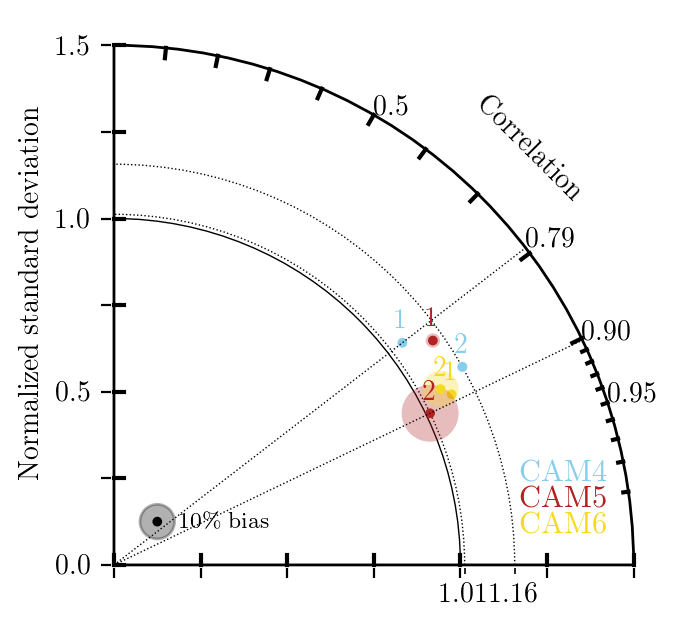

In [20]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 2 (ISCCP, MISR, and CALIPSO total cloud)

### Open files

In [21]:
og_clt_isccp = xr.open_dataset('%s/ISCCP.CLDTOT_ISCCPCOSP.nc' % (og_dir))
og_clt_misr = xr.open_dataset('%s/MISR.CLDTOT_MISR.nc' % (og_dir))
og_clt_caliop = xr.open_dataset('%s/CALIPSO.CLDTOT_CAL.nc' % (og_dir))

In [22]:
og_clt_isccp = og_clt_isccp.rename({'CLDTOT_ISCCPCOSP':'CLDTOT_ISCCP'})

### Open model files

In [23]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDTOT_ISCCP': og_clt_isccp['CLDTOT_ISCCP'], # these have to be dataarrays, not datasets
        'CLDTOT_MISR': og_clt_misr['CLDTOT_MISR'].where(np.abs(og_clt_misr['lat'])<60),
        'CLDTOT_CAL': og_clt_caliop['CLDTOT_CAL'],
    }

In [25]:
suffixes = ['atm/proc/tseries/month_1','','atm/proc/tseries/month_1']
# paths to use if I have pr
file_dirs = [save_dir,
             save_dir,
             save_dir]
_vars = ['CLDTOT_ISCCP','CLDTOT_MISR','CLDTOT_CAL']
case_dirs_n = [case_dirs,file_dirs,case_dirs]
# _vars = ['CLDTOT_ISCCP','CLDTOT_MISR','CLDTOT_CAL']

model_das = {}
for j,suf,_dir,_pdir in zip(_vars,suffixes,case_dirs,case_dirs_n):
#     print(j)
    var_files = []
    for i,ii in zip(_pdir,cases):
#         print(ii)
#         break
#         print(('%s/%s/%s/*.%s.*' % (i,ii,suf,j)))
        _f = glob.glob('%s/%s/%s/*.%s.*' % (i,ii,suf,j)) # get the correct file
        # open dataset
        print(_f[0])
        _ds = xr.open_dataset(_f[0])
        # Fix any weird month/year mismatch by weighting months equally.
#         if j == 'CLDTOT_MISR': 
#             _tvar = 'CLD_MISR'
#         else:
#             _tvar = j
        try:
            _da = _ds[j].groupby('time.month').mean('time').mean('month')
        except:
            _da = _ds['CLD_MISR'].groupby('time.month').mean('time').mean('month')
#             print(_f[0],_ds)
#             break
        # Interpolate to the control (observation) grid
        _da = _da.interp_like(cntlnames[j],method='nearest')
#         _da = _da.interp_like(cntlnames[j])
        var_files.append(_da)
    model_das[j] = var_files


/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.CLDTOT_ISCCP.200011-201012.nc


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.CLDTOT_ISCCP.200101-201012.nc
/glade/p/cesm/pcwg/jenkay/COSP/cesm21//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLDTOT_ISCCP.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam4_1deg_release_amip/cam4_1deg_release_amip.CLDTOT_MISR.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//cam5_1deg_release_amip/cam5_1deg_release_amip.CLDTOT_MISR.nc
/glade/u/home/jonahshaw/w/archive/taylor_files//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.CLDTOT_MISR.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.CLDTOT_CAL.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg

### Calculate

#### These are not being masked correctly. Should just use values below 60degrees.

In [26]:
# Case names
testnames = ('CAM4','CAM5','CAM6')
testmetrics = model_das

varnames = ['CLDTOT_ISCCP','CLDTOT_MISR','CLDTOT_CAL']

nvars = 3; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

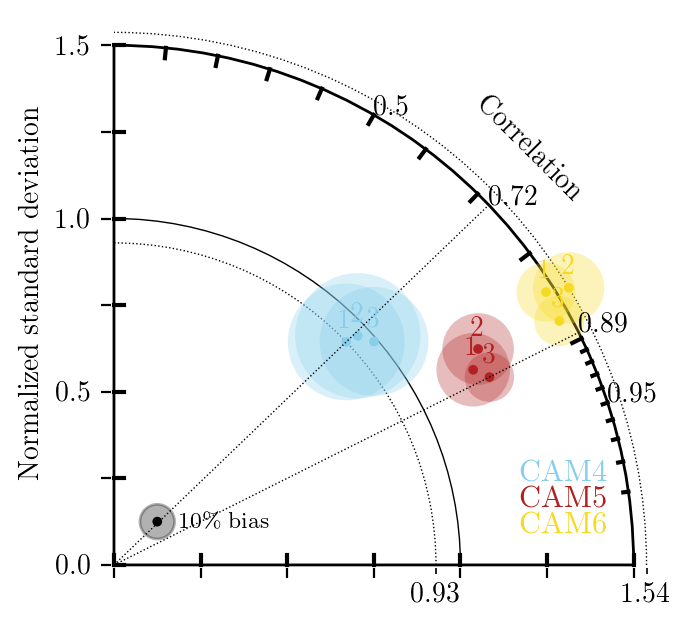

In [27]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 3 (CALIPSO low- mid- and high-level cloud)

### Open files

In [30]:
og_cll_caliop = xr.open_dataset('%s/CALIPSO.CLDLOW_CAL.nc' % (og_dir))
og_clm_caliop = xr.open_dataset('%s/CALIPSO.CLDMED_CAL.nc' % (og_dir))
og_clh_caliop = xr.open_dataset('%s/CALIPSO.CLDHGH_CAL.nc' % (og_dir))

### Open model files

In [31]:
cntlnames = {
        'CLDLOW_CAL': og_cll_caliop['CLDLOW_CAL'], # these have to be dataarrays, not datasets
        'CLDMED_CAL': og_clm_caliop['CLDMED_CAL'],
        'CLDHGH_CAL': og_clh_caliop['CLDHGH_CAL'],
    }

In [32]:
_vars = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']
suffix = 'atm/proc/tseries/month_1'

model_das = {}
for j in _vars:
    var_files = []
    for i,ii in zip(case_dirs,cases):
        _f = glob.glob('%s/%s/%s/*.%s.*' % (i,ii,suffix,j)) # get the correct file
        # open dataset
        print(_f[0])
        _ds = xr.open_dataset(_f[0])
        # apply time bounds  
        _ds = fix_cam_time(_ds)
        # select the AMIP period
        _ds = select_AMIP(_ds)
        # Fix any weird month/year mismatch by weighting months equally.
        try:
            _da = _ds[j].groupby('time.month').mean('time').mean('month')
#             _ds.close() # ?
        except:
            print(_ds)
        # Interpolate to the control (observation) grid
        _da = _da.interp_like(cntlnames[j],method='nearest')
#         _da = _da.interp_like(cntlnames[j])
        var_files.append(_da)
#         print(_f)
    model_das[j] = var_files
    

/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.CLDLOW_CAL.200011-201012.nc


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.CLDLOW_CAL.200101-201012.nc
/glade/p/cesm/pcwg/jenkay/COSP/cesm21//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLDLOW_CAL.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.CLDMED_CAL.200011-201012.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.CLDMED_CAL.200101-201012.nc
/glade/p/cesm/pcwg/jenkay/COSP/cesm21//f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLDMED_CAL.197901-201412.nc
/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012//cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.CLDHGH_CAL

#### Prep and plot

In [33]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDLOW_CAL': og_cll_caliop['CLDLOW_CAL'],
        'CLDMED_CAL': og_clm_caliop['CLDMED_CAL'],
        'CLDHGH_CAL': og_clh_caliop['CLDHGH_CAL'],
    }

# Case names
testnames = ('CAM4','CAM5','CAM6')
testmetrics = model_das

### Calculate

#### These are not being masked correctly. Should just use values below 60degrees.

In [34]:
varnames = ['CLDLOW_CAL','CLDMED_CAL','CLDHGH_CAL']

nvars = 3; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

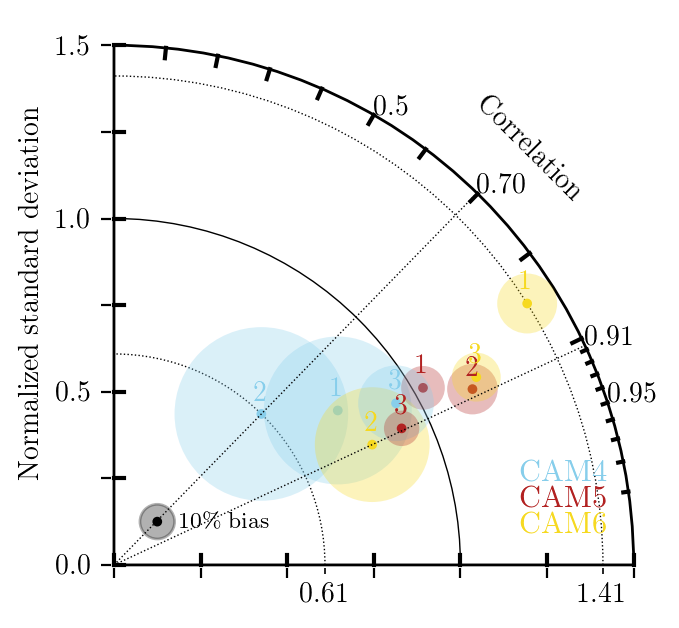

In [35]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

## Panel 4 (MISR low-topped thick and MODIS high-topped thick cloud)

### Open files

In [36]:
og_clmisr = xr.open_dataset('%s/MISR.CLDLOW_THICK_MISR.nc' % (og_dir))
og_clmodis = xr.open_dataset('%s/MODIS.CLDHGH_THICK_MODIS.nc' % (og_dir))

In [37]:
og_clmisr = og_clmisr.rename({'CLDLOW_THICK_MISR':'CLDTHCK_MISR'})
og_clmodis = og_clmodis.rename({'CLDHGH_THICK_MODIS':'CLDTHCK_MODIS'})

#### Set-up

In [38]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDTHCK_MISR': og_clmisr['CLDTHCK_MISR'], # these have to be dataarrays, not datasets
        'CLDTHCK_MODIS': og_clmodis['CLDTHCK_MODIS'],
    }

In [39]:
# suffixes = ['atm/proc/tseries/month_1','','atm/proc/tseries/month_1']
# paths to use if I have pr

_vars = ['CLDTHCK_MISR','CLDTHCK_MODIS']
_sdir = '/glade/u/home/jonahshaw/w/archive/taylor_files/'
model_das = {}
# for j,_dir in zip(_vars,case_dirs):
for j in _vars:
    print(j)
    var_files = []
    for ii in cases:
        print(ii)
#         print(('%s/%s/*.%s.*' % (_sdir,ii,j)))
        _f = glob.glob('%s/%s/*.%s.*' % (_sdir,ii,j)) # get the correct file
        # open dataset
        _ds = xr.open_dataset(_f[0])
        if j == 'CLDTHCK_MISR': 
            _tvar = 'CLD_MISR'
        if j == 'CLDTHCK_MODIS':
            _tvar = 'CLMODIS'
        # Fix any weird month/year mismatch by weighting months equally.
        _da = _ds[_tvar].groupby('time.month').mean('time').mean('month')
        # Interpolate to the control (observation) grid
        _da = _da.interp_like(cntlnames[j],method='nearest')
#         _da = _da.interp_like(cntlnames[j])
        var_files.append(_da)
    model_das[j] = var_files

CLDTHCK_MISR
cam4_1deg_release_amip
cam5_1deg_release_amip
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1
CLDTHCK_MODIS
cam4_1deg_release_amip
cam5_1deg_release_amip
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1


#### Prep and plot

In [40]:
# Control names dictionary (i.e. observations)
cntlnames = {
        'CLDTHCK_MISR': og_clmisr['CLDTHCK_MISR'], # these have to be dataarrays, not datasets
        'CLDTHCK_MODIS': og_clmodis['CLDTHCK_MODIS'],
    }

# Case names
testnames = ('CAM4','CAM5','CAM6')
testmetrics = model_das

### Calculate

#### These are not being masked correctly. Should just use values below 60degrees.

In [41]:
varnames = ['CLDTHCK_MISR','CLDTHCK_MODIS']

nvars = 2; ntest = 3;
cc = np.zeros([nvars,ntest])
ratio = np.zeros([nvars,ntest])
bias = np.zeros([nvars,ntest])

for ivar,var in enumerate(varnames): # iterate over the variables for a specific Taylor plot
    
    # Select observational dataarray:
    obs_da = cntlnames[var]
    obs_ds = obs_da        
    
    for itest,(name,metric) in enumerate(zip(testnames,testmetrics[var])): # iterate over the models to test/plot
        # Time average:
        test_ds = metric #[var]
        # Calculate Taylor diagram relevant variables:
        _bias,_corr,_rmsnorm,_ratio,_bias_abs = calculate(obs_ds,test_ds)
#         print(_bias[var],_corr[var],_rmsnorm[var],_ratio[var])
        cc[ivar,itest] = _corr
        ratio[ivar,itest] = _ratio
        bias[ivar,itest] = _bias
        
#         print(bias,corr,rmsnorm,ratio)

### Plot

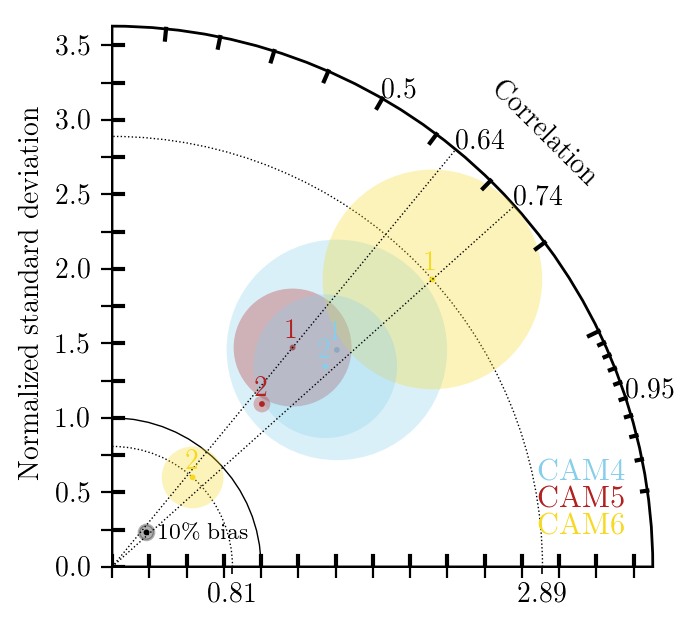

In [42]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['text.usetex'] = True

figure = plt.figure(figsize=(8,8))
figure.set_dpi(200)
testcolors = ('SkyBlue','Firebrick','#f6d921')

ax = figure.add_subplot(2,2,1,frameon=False)

taylor_diagram = taylor.Taylor_diagram(
        ax,cc,ratio,bias,
        casecolors=testcolors,
        varlabels=range(1,len(varnames)+1),
        )

# Reference bias bubbles, wut is this?
ref_bias = 0.1 # This is a 10% bias reference bubble in the lower-left corner
yloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
xloc = 0.05*taylor_diagram.xymax + ref_bias/2.0
circle = patches.Circle(
        (xloc,yloc),ref_bias/2.0,
        color="black",
        alpha=0.30,
    )
ax.add_patch(circle)

# Reference bias bubble points - centered at the reference bubble
circle = patches.Circle(
        (xloc,yloc),0.01,
        color="black",
    )
ax.add_patch(circle)

# Reference bias text
ax.text(
        xloc+ref_bias/2.0 + 0.01*taylor_diagram.xymax,yloc,
        "%.0f%s bias"%(ref_bias*100,r"\%"),
        color="Black",
        fontsize=8,
        horizontalalignment="left",
        verticalalignment="center"
    )

# Case labels
xloc = taylor_diagram.xymax*0.95
yloc = taylor_diagram.xymax*0.05
dy = taylor_diagram.xymax*0.05
for itest,testname in enumerate(testnames[::-1]):
    ax.text(
            xloc,yloc+itest*dy, # place these just above the dots
            testname,
            color=testcolors[::-1][itest],
            fontsize=11,
            horizontalalignment="right",
            verticalalignment="bottom",
#             fontweight='bold', # doesn't do anything
        )
    
mpl.rcParams['text.usetex'] = False

### Old

In [43]:
# start_dir = '/glade/u/home/jonahshaw/w/archive/taylor_files'

# for i in os.listdir(start_dir):
#     _path = '%s/%s' % (start_dir,i)
#     _file = os.listdir(_path)[0]
#     print(_file)
# #     print(os.listdir('%s/%s' % (start_dir,i)))
#     _temp = xr.open_dataset('%s/%s' % (_path,_file))
#     _temp = _temp.rename({'CLD_MISR':'CLDTOT_MISR'})
#     _temp.to_netcdf('%s/%s' % (_path,_file)+'1')